In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load datasets
customers = pd.read_csv('/content/drive/MyDrive/Customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Transactions.csv')


In [4]:
# Feature Engineering
def create_customer_features(customers, transactions):
    # Transaction-level aggregations
    transaction_summary = transactions.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean']
    }).reset_index()
    transaction_summary.columns = ['CustomerID', 'Transaction_Count', 'Total_Revenue', 'Avg_Transaction_Value', 'Total_Quantity', 'Avg_Quantity']

    # Merge with customer data
    customer_features = customers.merge(transaction_summary, on='CustomerID')

    # One-hot encode categorical variables
    customer_features = pd.get_dummies(customer_features, columns=['Region'])

    return customer_features

In [5]:
# Preprocessing
def preprocess_features(customer_features):
    # Drop non-numeric columns
    features_for_clustering = customer_features.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)

    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_for_clustering)

    return scaled_features


In [6]:
# Clustering with Multiple Metrics
def perform_clustering(scaled_features, max_clusters=10):
    results = []

    for n_clusters in range(2, max_clusters + 1):
        # Perform K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(scaled_features)

        # Calculate metrics
        silhouette = silhouette_score(scaled_features, cluster_labels)
        db_index = davies_bouldin_score(scaled_features, cluster_labels)

        results.append({
            'Clusters': n_clusters,
            'Silhouette_Score': silhouette,
            'Davies_Bouldin_Index': db_index
        })

    return pd.DataFrame(results)


In [7]:
# Visualization
def visualize_clusters(scaled_features, n_clusters):
    # Perform clustering with optimal number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Dimensionality reduction for visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(scaled_features)

    # Plotting
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1],
                          c=cluster_labels, cmap='viridis')
    plt.title(f'Customer Clusters (PCA Visualization)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)
    plt.show()

In [8]:
# Main Execution
customer_features = create_customer_features(customers, transactions)
scaled_features = preprocess_features(customer_features)


In [9]:
# Clustering Analysis
clustering_metrics = perform_clustering(scaled_features)
print("Clustering Metrics:")
print(clustering_metrics)

Clustering Metrics:
   Clusters  Silhouette_Score  Davies_Bouldin_Index
0         2          0.206054              1.730842
1         3          0.228264              1.573054
2         4          0.353724              1.220206
3         5          0.334021              1.084350
4         6          0.349923              1.093521
5         7          0.338912              1.048222
6         8          0.353258              0.991581
7         9          0.355042              0.964775
8        10          0.347548              0.986548


In [10]:
# Select optimal number of clusters (lowest Davies-Bouldin Index)
optimal_clusters = clustering_metrics.loc[clustering_metrics['Davies_Bouldin_Index'].idxmin(), 'Clusters']
print(f"\nOptimal Number of Clusters: {optimal_clusters}")


Optimal Number of Clusters: 9


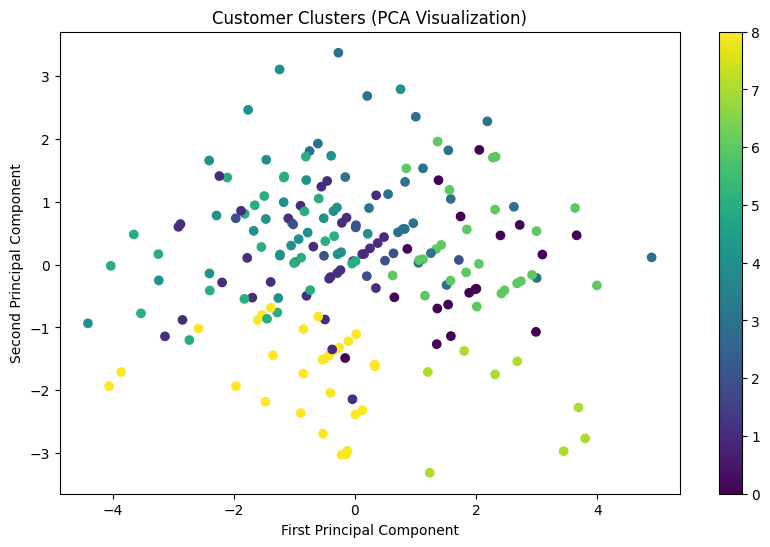

In [11]:
# Visualize clusters
visualize_clusters(scaled_features, optimal_clusters)